<a href="https://colab.research.google.com/github/abdelmonem808/Artificial-Intelligence-and-Machine-Vision/blob/main/Multi-Class-Image-Classification/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2
from tqdm import tqdm
from sklearn.utils import shuffle
from skimage.io import imread, imshow
from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
import keras.callbacks
from keras.callbacks import ModelCheckpoint
import random
from keras.applications import vgg16
from keras.preprocessing import image
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [ ]:
!git clone https://github.com/abdelmonem808/Artificial-Intelligence-and-Machine-Vision.git

In [6]:
train_dir = '/content/Artificial-Intelligence-and-Machine-Vision/Multi-Class-Image-Classification/train/train'
test_dir = '/content/Artificial-Intelligence-and-Machine-Vision/Multi-Class-Image-Classification/test/test'
pred_dir = '/content/Artificial-Intelligence-and-Machine-Vision/Multi-Class-Image-Classification/pred/pred'

In [7]:
# assign class labels
class_names = ['buildings','forest','glacier','mountain','sea','street']
class_labels = {class_name:i for i, class_name in enumerate(class_names)}
print(class_labels)

number_classes = len(class_names)

IMAGE_SIZE = (150,150)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [8]:
# usecase of os.listdir and os.path.join functions
for folder in os.listdir(train_dir):
    files_path = []
    for file in os.listdir(os.path.join(train_dir,folder)):
        files_path.append(file)
    print(len(files_path))

2274
2382
2191
2271
2512
2404


In [9]:
# define load_dataset function to load dataset with labels
def load_dataset():
    # create list of datasets
    datasets = [train_dir, test_dir]
    output = []
    
    for dataset in datasets:
        
        images1 = []
        labels1 = []
        print(f"loading {dataset}")
        
        for folder in os.listdir(dataset):
            # assign labels to each folder images
            label = class_labels[folder]
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                image_path = os.path.join(os.path.join(dataset, folder), file)
                # read the image files stored in image_path
                image_file = cv2.imread(image_path)
                image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB)
                image_file = cv2.resize(image_file, IMAGE_SIZE)
                
                images1.append(image_file)
                labels1.append(label)
                
        # convert the images and labels list to numpy array
        images1 = np.array(images1, dtype = 'float32')
        labels1 = np.array(labels1, dtype = 'int32')
        
        output.append((images1, labels1))
        print("Images file have been loaded")
                
    return output 

In [10]:
# load the data using above functions
((train_images, train_labels), (test_images, test_labels)) = load_dataset()

loading /content/Artificial-Intelligence-and-Machine-Vision/Multi-Class-Image-Classification/train/train


100%|██████████| 2404/2404 [00:02<00:00, 1189.59it/s]


Images file have been loaded
loading /content/Artificial-Intelligence-and-Machine-Vision/Multi-Class-Image-Classification/test/test


100%|██████████| 553/553 [00:00<00:00, 1048.91it/s]


Images file have been loaded


In [11]:
print("train dataset size")
len(train_images), len(train_labels)

train dataset size


(14034, 14034)

In [12]:
print("test dataset size")
len(test_images), len(test_labels)

test dataset size


(3000, 3000)

In [13]:
# shape of image dataset is 4D tensors
train_images.shape, test_images.shape

((14034, 150, 150, 3), (3000, 150, 150, 3))

In [14]:
# shuffle the train nad test datasets
(train_images, train_labels) = shuffle(train_images, train_labels, random_state=45)

In [15]:
(test_images, test_labels) = shuffle(test_images, test_labels, random_state=45)

In [16]:
# keeping 6000 data instances for training and testing our model
train_images = train_images[:6000]
train_labels = train_labels[:6000]

In [17]:
test_images = test_images[:1400]
test_labels = test_labels[:1400]

In [18]:
# normalize the images dataset
trn_images_norm = train_images/255.0
tst_images_norm = test_images/255.0

In [19]:
# let's see proportion of classes in train and test dataset
def proportion_labels(labels, dataset):
    series = pd.DataFrame(labels).reset_index()
    series.rename(columns = {0:'labels'}, inplace=True)
    final_s = series.groupby('labels').count().reset_index()                                          
    ticks1= [key for key in class_labels.keys()]
    
    # plot the pie chart and bar graph of labels
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.bar(np.array(final_s['labels']), np.array(final_s['index']))
    plt.xticks(ticks=np.array(final_s['labels']), labels=ticks1, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.grid(visible=True)
    plt.title("Number of images per class", size=14, weight='bold')
    
    plt.subplot(122)
    plt.pie(final_s['index'].ravel(),
            labels=ticks1,
            autopct='%1.2f%%',
            textprops={'fontweight':'bold'}
           )
    plt.title("proportion of classes", size=14, weight='bold')
    
    plt.suptitle(f"Proportion of {dataset} data", size=20, weight='bold')
    plt.show()
    
    return final_s

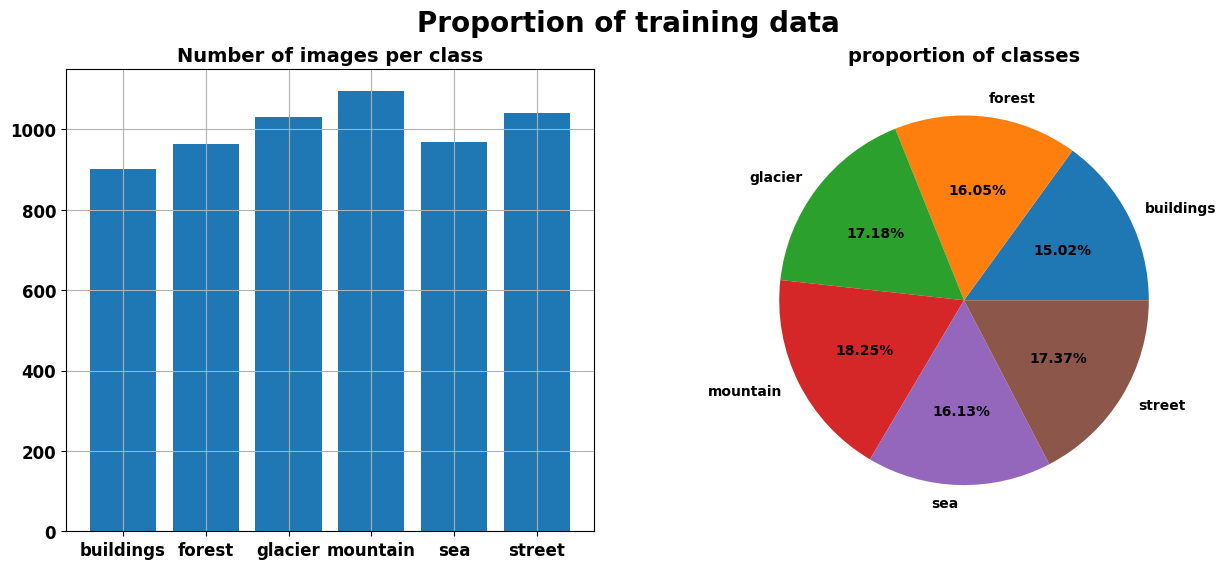

In [20]:
final_s = proportion_labels(train_labels, "training")

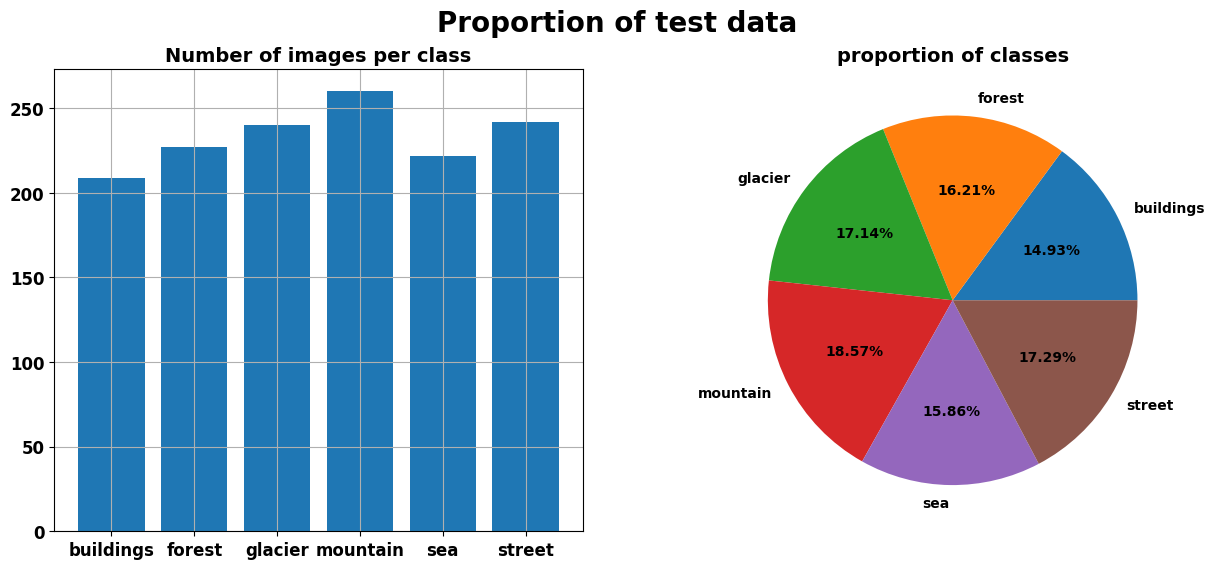

In [21]:
test_d = proportion_labels(test_labels, "test")

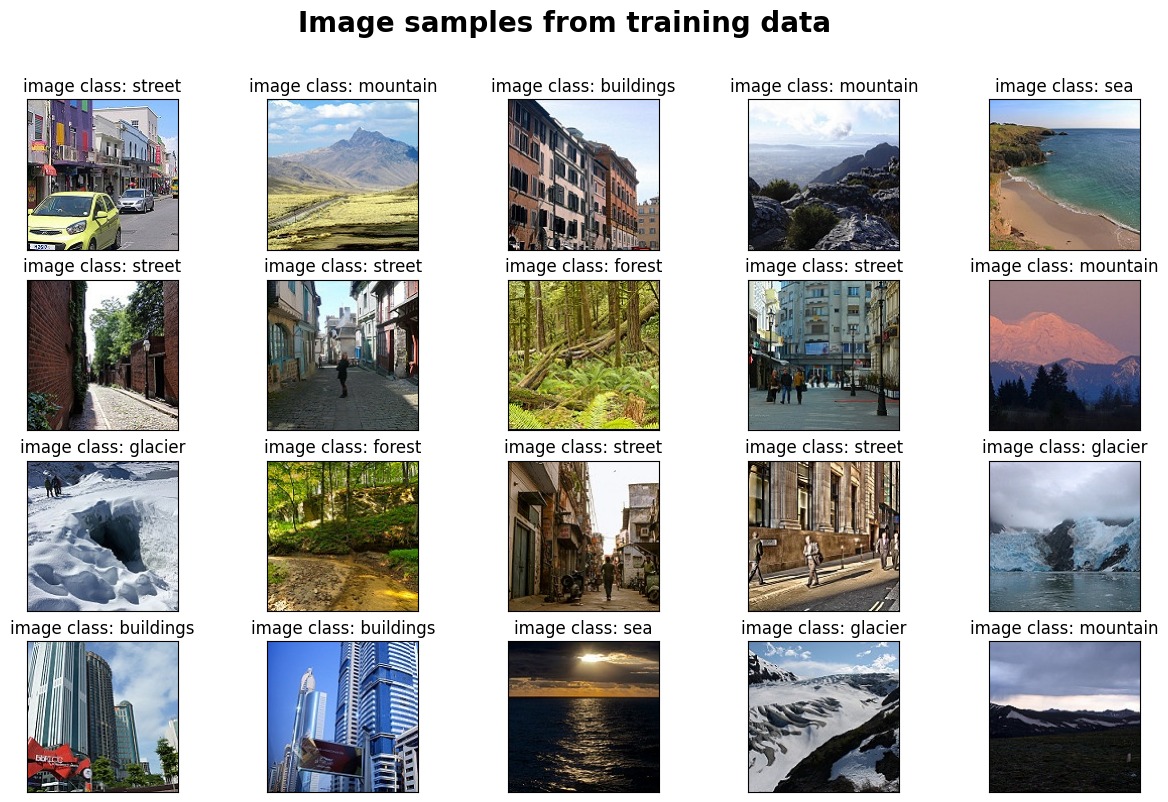

In [22]:
## plot 3*5 visualization of images
plt.figure(figsize=(15,9))
for idx, label in enumerate(train_labels[:20]):
    plt.subplot(4,5, idx+1)
    plt.imshow(trn_images_norm[idx])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'image class: {class_names[label]}')   
    
plt.suptitle(f'Image samples from training data', size=20, weight='bold')
plt.show()

In [23]:
# model architecture of first keras model
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [24]:
# convert labels to categorical 
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# compile the model with 'adam' optimizer
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy']
             )

# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history = model.fit(trn_images_norm, train_labels, batch_size=128, epochs=10, validation_data=(tst_images_norm, test_labels),
                   callbacks=callback_list)

# evalute the model
test_loss, test_acc = model.evaluate(tst_images_norm, test_labels, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/10
47/47 [==============================] - ETA: 0s - loss: 1.4672 - accuracy: 0.3927

47/47 [==============================] - 137s 3s/step - loss: 1.4672 - accuracy: 0.3927 - val_loss: 1.3830 - val_accuracy: 0.4614
Epoch 2/10
47/47 [==============================] - ETA: 0s - loss: 1.2281 - accuracy: 0.5065

47/47 [==============================] - 134s 3s/step - loss: 1.2281 - accuracy: 0.5065 - val_loss: 1.1090 - val_accuracy: 0.5550
Epoch 3/10
47/47 [==============================] - ETA: 0s - loss: 1.0954 - accuracy: 0.5623

47/47 [==============================] - 137s 3s/step - loss: 1.0954 - accuracy: 0.5623 - val_loss: 1.0402 - val_accuracy: 0.5914
Epoch 4/10
47/47 [==============================] - ETA: 0s - loss: 0.9856 - accuracy: 0.6188

47/47 [==============================] - 134s 3s/step - loss: 0.9856 - accuracy: 0.6188 - val_loss: 0.9269 - val_accuracy: 0.6600
Epoch 5/10
47/47 [==============================] - ETA: 0s - loss: 0.8975 - accuracy: 0.6573

47/47 [==============================] - 136s 3s/step - loss: 0.8975 - accuracy: 0.6573 - val_loss: 0.8892 - val_accuracy: 0.6693
Epoch 6/10
47/47 [==============================] - ETA: 0s - loss: 0.8081 - accuracy: 0.6938

47/47 [==============================] - 138s 3s/step - loss: 0.8081 - accuracy: 0.6938 - val_loss: 0.8239 - val_accuracy: 0.6957
Epoch 7/10
47/47 [==============================] - ETA: 0s - loss: 0.7731 - accuracy: 0.7075

47/47 [==============================] - 137s 3s/step - loss: 0.7731 - accuracy: 0.7075 - val_loss: 0.7591 - val_accuracy: 0.7250
Epoch 8/10
47/47 [==============================] - ETA: 0s - loss: 0.7269 - accuracy: 0.7252

47/47 [==============================] - 134s 3s/step - loss: 0.7269 - accuracy: 0.7252 - val_loss: 0.7513 - val_accuracy: 0.7193
Epoch 9/10
47/47 [==============================] - ETA: 0s - loss: 0.7052 - accuracy: 0.7348

47/47 [==============================] - 136s 3s/step - loss: 0.7052 - accuracy: 0.7348 - val_loss: 0.7022 - val_accuracy: 0.7471
Epoch 10/10
47/47 [==============================] - ETA: 0s - loss: 0.6633 - accuracy: 0.7580

47/47 [==============================] - 134s 3s/step - loss: 0.6633 - accuracy: 0.7580 - val_loss: 0.6961 - val_accuracy: 0.7436
test loss and accuracy: 0.6961116790771484 0.743571400642395


In [25]:
# saving model in H5 format
model.save('image_classifier_cnn1.h5')

In [26]:
# load the prediction data and predict class on unseen data
def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

images_paths = getImagePaths(pred_dir)
len(images_paths)

7301

In [27]:
# images path list to numpy array using cv2.imread module
file_array = []

for file in images_paths[:9]:
    files = cv2.imread(file)/255.0 
    file_array.append(files)
    
file_array = np.array(file_array)

In [28]:
# vector of prected probability of each class by our model
predictions = model.predict(file_array)
predictions.shape

1/1 [==============================] - 0s 207ms/step


(9, 6)

In [29]:
# prediciton of 'index 0'image from 'preds_dir' image directory
preds_index = np.argmax(predictions, axis=1)
preds_index

array([4, 2, 4, 4, 5, 5, 4, 1, 0])

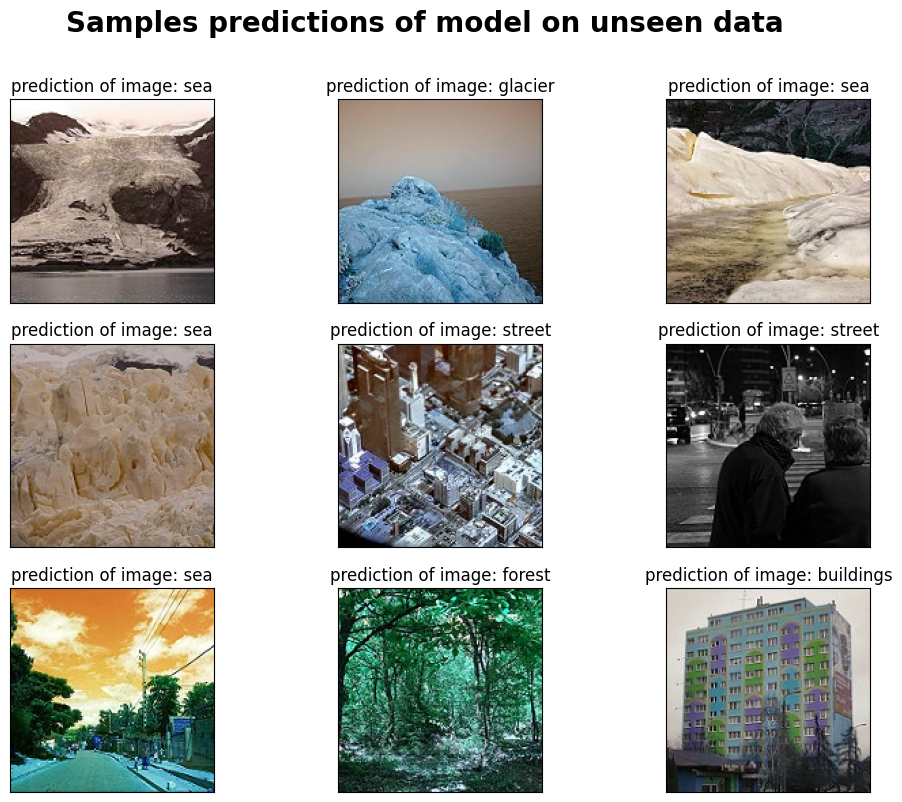

In [30]:
# sample prediciton on unseen data using model
plt.figure(figsize=(12,9))

for idx, i in enumerate(preds_index):
    plt.subplot(3,3, idx+1)
    plt.imshow(file_array[idx])
    plt.title(f"prediction of image: {class_names[i]}")
    plt.xticks([])
    plt.yticks([])
    
plt.suptitle("Samples predictions of model on unseen data", size=20, weight='bold')
plt.show()

In [31]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)
    
    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()
    
    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()
    
    plt.show()

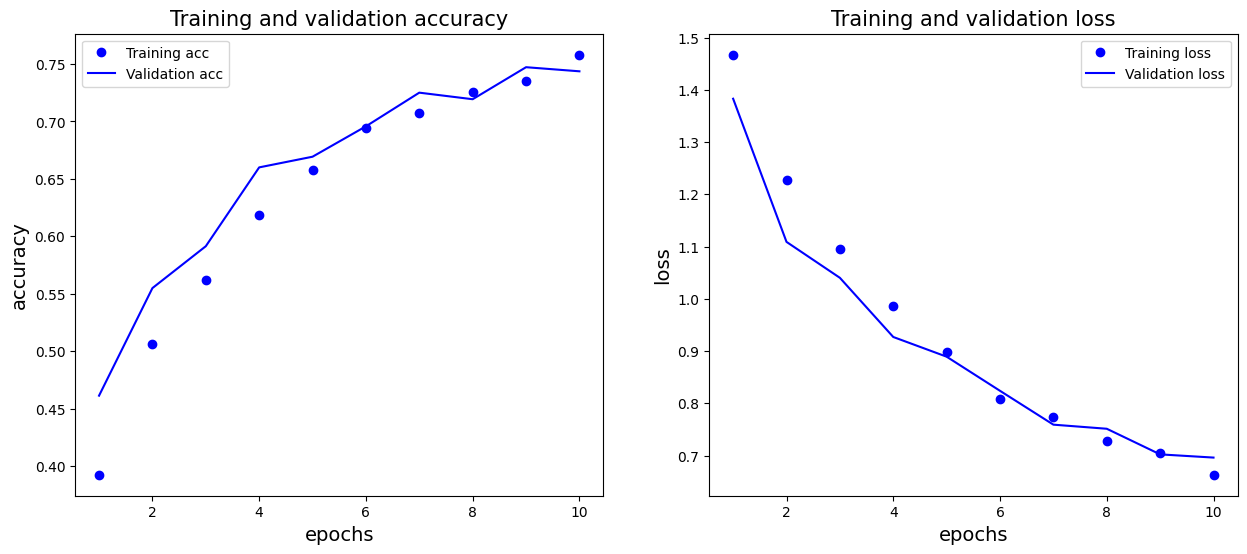

In [32]:
# call the function to plot the curves
plot_loss_accuracy(history)

In [33]:
# prediction on validation data to check the errors
preds = model.predict(tst_images_norm)
print("Shape of the prediction indexs", preds.shape)

# apply argmax function over a rows to find 
predictions_f = np.argmax(preds, axis=1)
print("Shape of predicitons vector:", predictions_f.shape)

44/44 [==============================] - 8s 181ms/step
Shape of the prediction indexs (1400, 6)
Shape of predicitons vector: (1400,)


In [34]:
# convert categorical test labels to numpy array of 1 dim
test_list = []
for i in test_labels:
    index1 = list(np.argwhere(i).reshape(1))[0]
    test_list.append(index1)

test_array = np.array(test_list)
print("shape of actual test array:", test_array.shape)

shape of actual test array: (1400,)


In [35]:
def mislabled_images(class_names, test_images, test_labels, predicted_labels):
    # find the  mislabeled images using np.where and return array of mislabled images
    mislabels = (test_labels == predicted_labels)
    mislabels_index = np.array(np.where(mislabels == False)).ravel()
    mislables_images = test_images[mislabels_index]
    mislables_labels = predicted_labels[mislabels_index]
    
    print("Number of total mislabeled images", mislables_labels.shape)
    
    # plot the 20 mislabeled images
    plt.figure(figsize=(15,9))
    for idx, label in enumerate(mislables_labels[:20]):
        plt.subplot(4,5, idx+1)
        plt.imshow(mislables_images[idx])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Predicted class: {class_names[label]}')   
    
        plt.suptitle(f'Mislabeled images from test data', size=20, weight='bold')
    plt.show()  
    return mislables_labels

Number of total mislabeled images (359,)


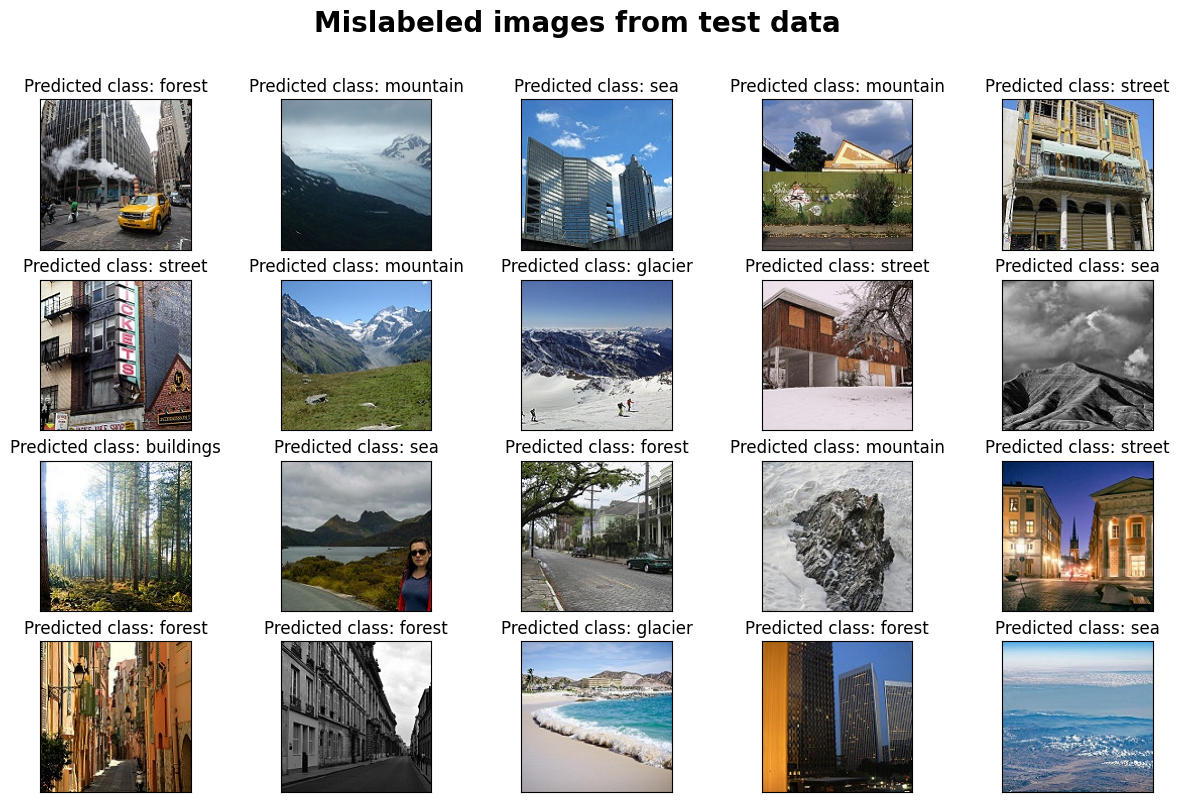

In [36]:
mislables_labels = mislabled_images(class_names, tst_images_norm, test_array, predictions_f)

In [3]:
# next up model using pretrained model vgg16 to improve accuracy to 85-90% and machine visualization
# initializing convolutional base of vgg16
conv_base = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3)
                 )

conv_base.summary()

NameError: ignored

In [2]:
# Extract training feature map from vgg16 conv_base
train_featuremap = conv_base.predict(trn_images_norm)
test_featuremap = conv_base.predict(tst_images_norm) 

NameError: ignored

In [1]:
# print the shape of output tensors from convolutionla base -vgg16
train_featuremap.shape, test_featuremap.shape

NameError: ignored

In [ ]:
# train the model by adding dense layers on top of extracted features
model2 = models.Sequential()
model2.add(layers.Flatten(input_shape=(4,4,512)))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dropout(0.4))
model2.add(layers.Dense(6, activation='softmax'))
model2.summary()

In [ ]:
# compile the model with 'RMSprop' optimizer
model2.compile(loss='categorical_crossentropy',
             optimizer= tf.keras.optimizers.RMSprop(learning_rate=2e-5),
             metrics=['accuracy']
             )

# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

In [ ]:
# fit the model to datr and save the model statistics to result instance
result = model2.fit(train_featuremap, train_labels,
                   batch_size=128,
                   epochs=30,
                   validation_data=(test_featuremap, test_labels),
                   callbacks=callback_list
                   )

# print the final test accuracy and loss
tst_loss, tst_acc = model2.evaluate(test_featuremap, test_labels, verbose=0)
print("Test loss and accuracy of model2:", tst_loss, tst_acc)

In [ ]:
# saving model2 with h5 extension
model2.save("image_classifier_cnn2.h5")

In [ ]:
# plotting loss and accuracy curves
plot_loss_accuracy(result)

In [ ]:
# create function of samples prediction of training data and build next model with fine-tuning
pred = model2.predict(test_featuremap)
predictions = np.argmax(pred, axis=1)
predictions.shape

In [ ]:
mislables_labels= mislabled_images(class_names, tst_images_norm, test_array, predictions)

In [ ]:
def images_classifier(images_paths, class_names):
    file_array2 = []
    
    for file2 in images_paths:
        files2 = cv2.imread(file2)/255.0 
        file_array2.append(files2)
        
    file_array2 = np.array(file_array2)
    
    # run thorought the convolutional base and then model2
    img_arr = conv_base.predict(file_array2)
    
    # run img_arr of shape (9,4,4,512) through model2
    img_pred = model2.predict(img_arr)
    img_predf = np.argmax(img_pred, axis=1)
    print("shape of the predicted array:", img_predf.shape)
    
    # plot the 20 unseen images and predicted class
    plt.figure(figsize=(17,13))
    
    for idx, i in enumerate(img_predf):
        plt.subplot(4,5, idx+1)
        plt.imshow(file_array2[idx])
        plt.title(f"prediction of image: {class_names[i]}")
        plt.xticks([])
        plt.yticks([])
    
    plt.suptitle("Samples predicition of model2 on unseen data", size=20, weight='bold')
    plt.show()

In [ ]:
images_classifier(images_paths[:20], class_names)

In [ ]:
# load the first model we developed using load_model of keras
model3 = load_model('/content/image_classifier_cnn1.h5')
model3.summary()

In [ ]:
# let's take one simple image from unseen image set 
image_path = '/content/Artificial-Intelligence-and-Machine-Vision/Multi-Class-Image-Classification/pred/pred/10092.jpg'

# load and preprocess the image instance
img = image.load_img(image_path, target_size=(150,150))
print("Data type of image instance is: ", type(img))
img_tensor = image.img_to_array(img) # convert to numpy array
img_tensor = np.expand_dims(img_tensor, axis=0) # expand dimensions to 4D
img_tensor /= 255. 
print("Shape of image tensor:", img_tensor.shape)

In [ ]:
# visualize the image
plt.imshow(img_tensor[0])
plt.show()

In [ ]:
# extract an output layers from loaded model3
layer_outputs = [layer.output for layer in model3.layers[:10]]
print("Layer outputs:\n",layer_outputs)

# create a activation model instance with output of each layer given the input tensor
activation_model = models.Model(inputs=model3.input, outputs=layer_outputs)
print("===============================================================")
# predict the outputs of each layer given the input of an image tensor
activations = activation_model.predict(img_tensor) # returns the list of 10 arrays
first_layer_active = activations[0]
first_layer_active.shape

In [ ]:
# now let's visualize one of the the channels out of total 32 channels
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(first_layer_active[0,:,:,10])
plt.title("Channel 10")
plt.subplot(1,3,2)
plt.imshow(first_layer_active[0,:,:,20])
plt.title("Channel 20")
plt.subplot(1,3,3)
plt.imshow(first_layer_active[0,:,:,30])
plt.title("Channel 30")
plt.suptitle("Encoding of channels 10,20,&30", size=15, weight='bold')
plt.show()

In [ ]:
layer_names = []
for layer in model3.layers[:10]:  # iterate through each layer
    layer_names.append(layer.name)
    
images_per_row = 16 

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]  # features in featuremap
    
    size = layer_activation.shape[1] # shape of featuremap
    n_cols = n_features//images_per_row
    display_grid = np.zeros((size*n_cols, images_per_row*size)) # display grid of all featuremaps in layer
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:,:,col*images_per_row + row]
            channel_image -= channel_image.mean() # post-precess of the featuremap
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image,0,255).astype('uint8')
            display_grid[col*size: (col + 1)*size,
                         row*size: (row + 1)*size] = channel_image
    scale = 1./size
    
    plt.figure(figsize=(scale*display_grid.shape[1],
                        scale*display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')